[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Exploring Different Vision Tasks with Florence-2

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/florence-2/)
[![arXiv](https://img.shields.io/badge/arXiv-2311.06242-b31b1b.svg)](https://arxiv.org/abs/2311.06242)

## Setup

### Configure your API keys

To run Florence-2, you need to provide your HuggingFace Token. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store HuggingFace Access Token under the name `HF_TOKEN`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Wed Jul  3 11:47:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Install extra dependencies

 Let's download the model checkpoint and configure it so that you can fine-tune it later on.

In [1]:
!pip install -q transformers flash_attn timm einops supervision==0.22.0rc1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.9/126.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 13.7 MB/s eta 0:00:00


### Download example data

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


**NONE:** Let's download few example images. Feel free to use your images or videos.

In [3]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/inference/license_plate_1.jpg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/handwritten-text.jpg -P {HOME}/data

## Load pre-trained Florence-2 model

Load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor` classes from the transformers library. Note that you need to pass `trust_remote_code` as `True` since this model is not a standard transformers model.

In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoProcessor

# CHECKPOINT = "microsoft/Florence-2-base-ft"
CHECKPOINT = "microsoft/Florence-2-large-ft"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Run inference with pre-trained Florence-2 model

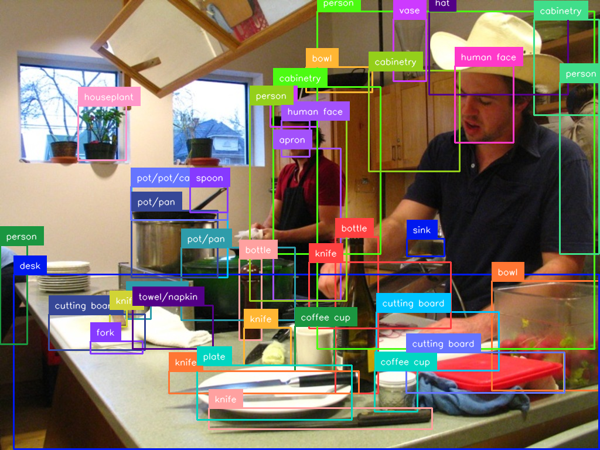

In [6]:
# @title Example object detection (`<OB>`) inference

import supervision as sv
from PIL import Image

image = Image.open(f"/content/3a7e863231dbd146.jpg")
text = "<OD>"
task = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=image.size)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

**NOTE:** Note that out of the box Florence-2 detects far more classes than the typical model pretreated on the COCO dataset.

In [7]:
 # @title Wrap inference code into utility function

def run_inference(image: Image, task: str, text: str = ""):
    prompt = task + text
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(generated_text, task=task, image_size=image.size)

**NOTE:** Florence-2 offers 3 types of imag caption tasks - `<CAPTION>`, `<DETAILED_CAPTION>`, `<MORE_DETAILED_CAPTION>` differing in level of detail. Let's compare the results obtained.

In [14]:
# @title Example `<CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"/content/00c3e6527e715e60.jpg")
task = "<CAPTION>"

response = run_inference(image=image, task=task)
response

{'<CAPTION>': 'Two people standing next to a table with pictures on it.'}

In [16]:
# @title Example `<DETAILED_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"/content/00c3e6527e715e60.jpg")
task = "<DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
response

{'<DETAILED_CAPTION>': 'In this image we can see two people standing on the floor. We can also see a table with a cloth, some pictures pasted on it, a group of chairs, a display screen with some text on it and a roof with some ceiling lights.'}

In [17]:
# @title Example `<MORE_DETAILED_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"/content/00c3e6527e715e60.jpg")
task = "<MORE_DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
response

{'<MORE_DETAILED_CAPTION>': 'Two people are standing next to a table. The table has pictures on it. There is a projector screen behind the people. '}

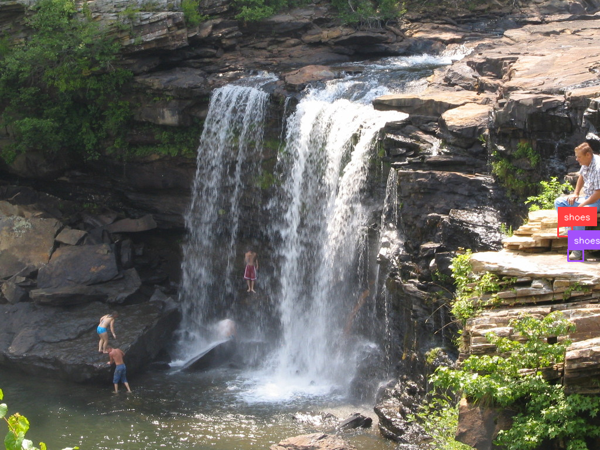

In [23]:
# @title Example `<CAPTION_TO_PHRASE_GROUNDING>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"/content/00ebef2d2f583f3c.jpg")
task = "<CAPTION_TO_PHRASE_GROUNDING>"
text = "shoes"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In this image we can see a person sitting on the rocks. We can also see the waterfall, some people in the water, some plants, the rocks and the trees.


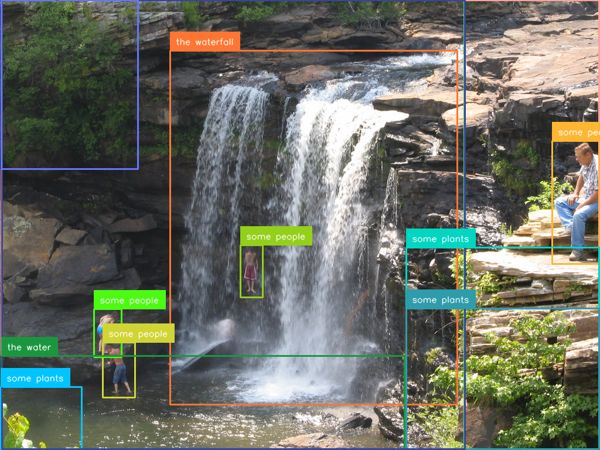

In [24]:
# @title Example `<DETAILED_CAPTION>` + `<CAPTION_TO_PHRASE_GROUNDING>` combo inference

import supervision as sv
from PIL import Image

image = Image.open(f"/content/00ebef2d2f583f3c.jpg")
task = "<DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
text = response[task]

task = "<CAPTION_TO_PHRASE_GROUNDING>"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))

print(text)
image

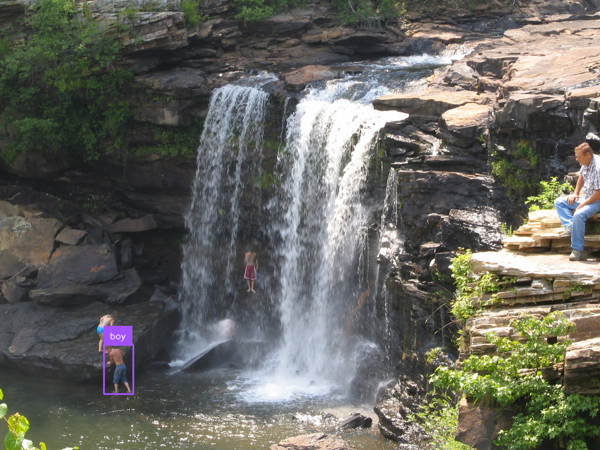

In [27]:
# @title Example `<OPEN_VOCABULARY_DETECTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"/content/00ebef2d2f583f3c.jpg")
task = "<OPEN_VOCABULARY_DETECTION>"
text = "boy"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

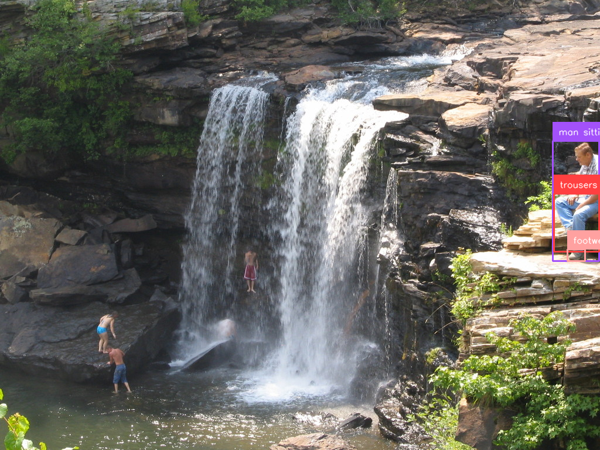

In [28]:
# @title Example `<DENSE_REGION_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"/content/00ebef2d2f583f3c.jpg")
task = "<DENSE_REGION_CAPTION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

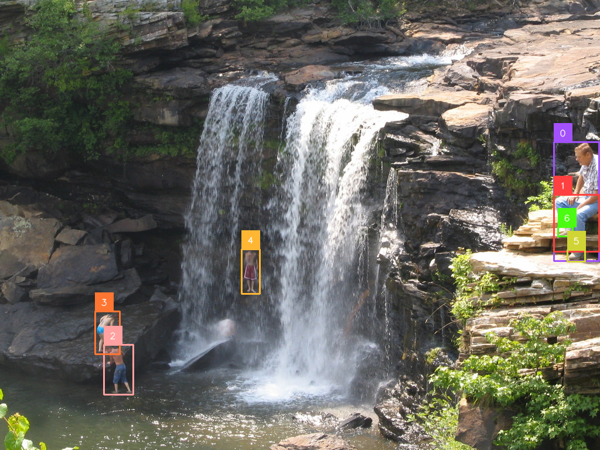

In [29]:
# @title Example `<REGION_PROPOSAL>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"/content/00ebef2d2f583f3c.jpg")
task = "<REGION_PROPOSAL>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

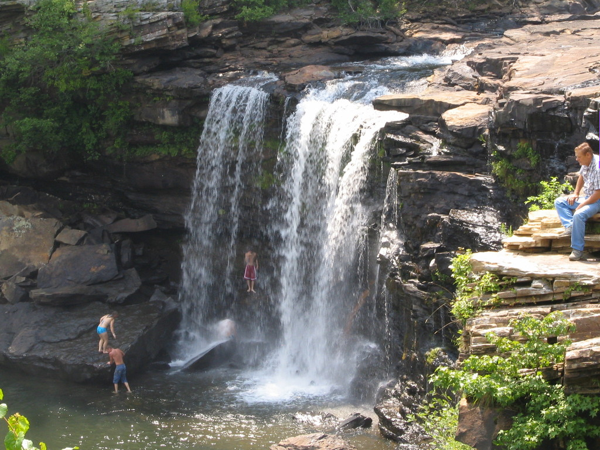

In [30]:
# @title Example `<OCR_WITH_REGION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"/content/00ebef2d2f583f3c.jpg")
task = "<OCR_WITH_REGION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    text_scale=3,
    text_thickness=4
)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

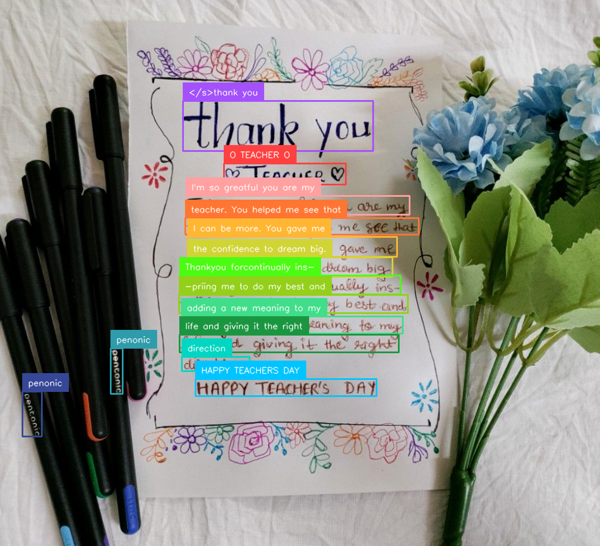

In [31]:
import supervision as sv
from PIL import Image

image = Image.open(f"/content/1c739b5fc61bd365fe6288e2da9015e2.jpg")
task = "<OCR_WITH_REGION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [32]:
# @title Example `<OCR>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"/content/1c739b5fc61bd365fe6288e2da9015e2.jpg")
task = "<OCR>"

response = run_inference(image=image, task=task)
response[task]

"thank youO TEACHER OI'm so greatful you are myteacher. You helped me see thatI can be more. You gave meIcan be more You give methe confidence to dream big.Thank you forcontinually ins-priing me to do my best andadding a new meaning to mylife and giving it the rightpentonicdirectionHAPPY TEACHERS DAYpentonic"

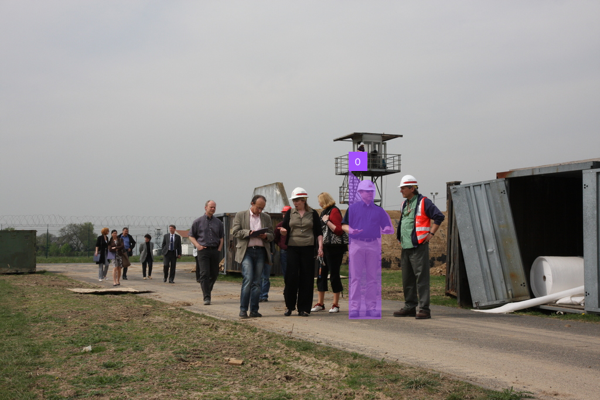

In [36]:
# @title Example `<REFERRING_EXPRESSION_SEGMENTATION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"/content/00be2382889169cb.jpg")
task = "<REFERRING_EXPRESSION_SEGMENTATION>"
text = "man"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = mask_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [ ]:
!pip install -q jupyter_bbox_widget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.6 MB/s eta 0:00:00


In [ ]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True
IMAGE_PATH = f"{HOME}/data/dog-3.jpeg"

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 156, 'y': 381, 'width': 276, 'height': 558, 'label': ''}]

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 243, 'y': 733, 'width': 52, 'height': 211, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

image = Image.open(IMAGE_PATH)
w, h = image.size
box = box / np.array([w, h, w, h])
box = box * 1000
box = box.astype(np.int32)
box

array([216, 297, 600, 733], dtype=int32)

In [ ]:
region = "".join([f"<loc_{coordinate}>" for coordinate in box])
region

'<loc_216><loc_297><loc_600><loc_733>'

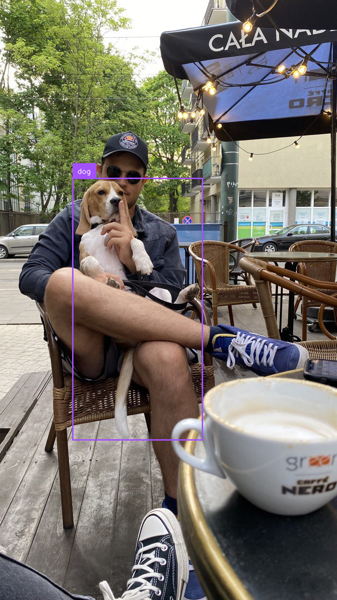

In [ ]:
# @title Example `<REGION_TO_CATEGORY>` inference

import supervision as sv
from PIL import Image

task = "<REGION_TO_CATEGORY>"
image = Image.open(IMAGE_PATH)

response = run_inference(image=image, task=task, text=region)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
detections.xyxy = (detections.xyxy / 1000 * np.array([w, h, w, h])).astype(np.int32)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)

image.thumbnail((600, 600))
image

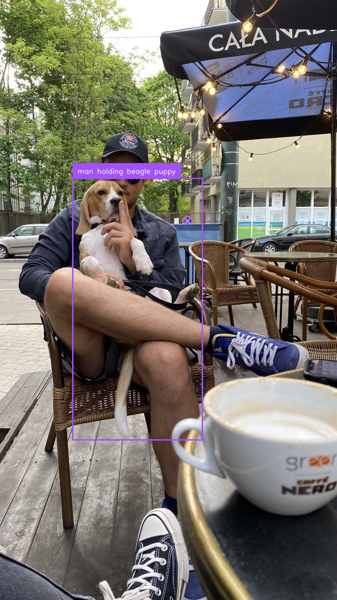

In [ ]:
# @title Example `<REGION_TO_DESCRIPTION>` inference

import supervision as sv
from PIL import Image

task = "<REGION_TO_DESCRIPTION>"
image = Image.open(IMAGE_PATH)

response = run_inference(image=image, task=task, text=region)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
detections.xyxy = (detections.xyxy / 1000 * np.array([w, h, w, h])).astype(np.int32)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)

image.thumbnail((600, 600))
image

# Congratulations

⭐️ If you enjoyed this notebook, [**star the Roboflow Notebooks repo**](https://https://github.com/roboflow/notebooks) (and [**supervision**](https://github.com/roboflow/supervision) while you're at it) and let us know what tutorials you'd like to see us do next. ⭐️